## Recipe Ingredient Analysis Notebook

### Objectives and Approach

In this notebook, I will work on analyzing ingredients from a Spanish recipe dataset with the following goals:

- **Identify whether a given word or phrase is an ingredient or not**, using a combination of rule-based checks and embedding-based similarity.
- **Detect duplicate ingredients** that appear in different forms (e.g., gender variations like *quemado/quemada*, singular/plural forms) to clean and consolidate the ingredient list.
- **Find substitute or similar ingredients** by leveraging word embeddings, helping with recipe modification or alternative recommendations.
- **Create meaningful categories or clusters of ingredients** to organize them better (e.g., spices, vegetables, dairy).

The code will be designed modularly, allowing us to switch between different embedding models or techniques easily.  
Initially, I will use a **custom-trained Word2Vec model** built on our Spanish recipe corpus to capture the semantic relationships between ingredients.


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin


import gensim

In [60]:
# Load the embedding model (assuming it's a Word2Vec model saved as 'w2v_ngram.model')
embedding_model = gensim.models.Word2Vec.load('models/w2v_ngram.model')

def get_embeddings(words, model=embedding_model):
    """
    Returns a list of embeddings for the given list of words.
    If a word is not in the vocabulary, returns None for that word.
    """
    embeddings = {}
    for word in words:
        if word in model.wv:
            embeddings[word] = (model.wv[word])
    
    res = pd.DataFrame.from_dict(embeddings, orient= 'index')
    return res.reindex(words).to_numpy()

get_embeddings(['harina', 'pimentón_dulce', 'hacer'], embedding_model).shape

(3, 300)

### Ingredient Classification: Yes or No?

This section focuses on building a classification model to determine whether a given word or n-gram represents an **ingredient** or **not**.

We will experiment with the following models:

- **Naive Bayes**: Chosen for its simplicity, efficiency, and reasonable performance on text-based data.
- **Logistic Regression**: A strong baseline for binary classification that performs well with high-dimensional data.
- **Random Forest**: Provides good generalization and handles non-linear relationships, helping with noisy or imperfect labels.

### Why we're not using:
- **K-Nearest Neighbors (KNN)**: Too slow for prediction on large, imbalanced datasets.
- **Support Vector Machines (SVM)**: Not ideal for large datasets and may struggle when classes aren't linearly separable.
- **Decision Trees**: Prone to overfitting, especially with noisy labels.

### Considerations:
- Our training dataset was **manually labeled**, so it's crucial the model is **robust to mislabeled examples** or outliers.
- Evaluation will include manual inspection of edge cases and common mistakes.

### Test Cases:
- `"harina de trigo"` → ingredient  
- `"precalentar el horno"` → not an ingredient  
- `"queso rallado"` → ingredient  
- `"batir los huevos"` → not an ingredient  

In [ ]:
data =pd.read_csv("data/is_ingrediente.csv").rename(columns = {'Unnamed: 0':'word'})
data.sample(6)

,word,is_ingrediente
4461,pimiento_amarillo,True
447,elaboración,False
404,mezclamos,False
2722,aderezar,False
4778,adquieran,False
5864,agrégalo,False


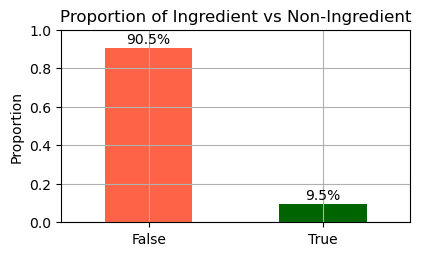

In [52]:
plt.figure(figsize= (4.5,2.5))
data['is_ingrediente'].value_counts(normalize=True).plot(
    kind='bar',
    color=['tomato', 'darkgreen'],
    rot=0
)
plt.title('Proportion of Ingredient vs Non-Ingredient')
plt.xlabel(None)
plt.ylabel('Proportion')
plt.xticks([0, 1], ['False', 'True'])
plt.ylim((0,1))

# Add text labels to each bar
for i, v in enumerate(data['is_ingrediente'].value_counts(normalize=True)):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', va='bottom', fontsize= 10)

plt.grid()
plt.show()


In [ ]:
class EmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that converts a list of words/phrases
    to their embedding vectors using a gensim Word2Vec model.
    If a word is not in the model, returns a zero vector of the same dimension.
    """
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is expected to be a list or array of strings
        return get_embeddings(X, self.model)